In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import sys
sys.path.append("../")
import models
from utils.training import train_meta_model, train_gp
from utils.data_utils import ctxt_trgt_split
import dill
from timeit import default_timer as timer

torch.set_default_dtype(torch.float64)

%load_ext autoreload
%autoreload 2

### Download Data

In [2]:
# fetch dataset 
tetouan_dataset = fetch_ucirepo(id=849) 
  
# data (as pandas dataframes) 
all_X = tetouan_dataset.data.features 
all_y = tetouan_dataset.data.targets 

# what features does the dataset have?
print(all_X.columns)

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows'],
      dtype='object')


##### Convert to normalised torch tensors, split.

In [3]:
date_times = pd.to_datetime(all_X['DateTime'], format="%m/%d/%Y %H:%M")
first_datetime = date_times[0]
# convert time to days
dt = torch.tensor(((date_times - first_datetime).dt.total_seconds() / (24 * 3600)).astype(float).values).unsqueeze(-1)
temp_humid = torch.tensor(all_X[['Temperature', 'Humidity']].values)

feb_idx = int((31 / 365) * dt.shape[0])
mar_idx = int((59 / 365) * dt.shape[0])
apr_idx = int((90 / 365) * dt.shape[0])

# pre-march zones 1 and 2 datasets for training:
# unnorm_X = torch.cat((dt, temp_humid), -1)[:feb_idx]
# unnorm_ys = [torch.tensor(all_y[col].values)[:feb_idx] for col in all_y.columns]
# pre-march datasets:
unnorm_X = torch.cat((dt, temp_humid), -1)[:mar_idx]
unnorm_ys = [torch.tensor(all_y[col].values)[:mar_idx] for col in all_y.columns]


X_mean, X_std = unnorm_X.mean(0), unnorm_X.std(0)
z1z2_unnorm_ys_cat = torch.cat((unnorm_ys[0], unnorm_ys[1]), dim=0)
y_mean, y_std = z1z2_unnorm_ys_cat.mean(), z1z2_unnorm_ys_cat.std()

X = (unnorm_X - X_mean) / X_std
ys = [(unnorm_y - y_mean) / y_std for unnorm_y in unnorm_ys]

training_tasks = [(X, ys[0]), (X, ys[1])]



# zone 3 data split into pre march and march for context and target (extrapolation task)

zone3_extrap_context = (X, ys[2])

# target dataset for zone 3 extrapolation task:
mar_unnorm_X = torch.cat((dt, temp_humid), -1)[mar_idx:apr_idx]
mar_unnorm_y3 = torch.tensor(all_y.iloc[:,2].values)[mar_idx:apr_idx]

z3_mar_X = (mar_unnorm_X - X_mean) / X_std
z3_mar_y = (mar_unnorm_y3 - y_mean) / y_std

zone3_extrap_target = (z3_mar_X, z3_mar_y)



# zone 3 jan/feb data split into random context and target (interpolation task)

torch.manual_seed(42)
z3_xc, z3_yc, z3_xt, z3_yt = ctxt_trgt_split(*zone3_extrap_context, ctxt_proportion_range=(0.49999, 0.50001))
zone3_interp_context = (z3_xc, z3_yc)
zone3_interp_target = (z3_xt, z3_yt)

In [ ]:
# shows the context and target data split for zone 3 extrapolation task

plt.scatter(zone3_extrap_context[0][:,0], zone3_extrap_context[1])
plt.scatter(zone3_extrap_target[0][:,0], zone3_extrap_target[1])
plt.show()

In [ ]:
# shows the context and target data split for zone 3 interpolation task

plt.scatter(zone3_interp_context[0][:,0], zone3_interp_context[1])
plt.scatter(zone3_interp_target[0][:,0], zone3_interp_target[1])
plt.show()

### Initialise Models

In [ ]:
cnn_chans = [128, 128, 128]
kernel_size = 3
Z_net_width = 128
Z_net_depth = 3
use_transformer = False
num_induc = 256
d_k = 16
tetouan_grid_spacing = [1.25e-2, 5e-1, 5e-1]
p1_raw = 1.0 # daily period
p2_raw = 7.0 # weekly period
nonlinearity = torch.nn.ReLU()

# prior = models.GPPrior(covariance_function='tetouan',
#                           num_inputs=3,
#                           p1=p1_raw / X_std[0],
#                           p2=p2_raw / X_std[0],
#                          )

# sgnp = models.SparseGaussianNeuralProcess(
#     x_dim=3,
#     num_inducing=num_induc,
#     likelihood=models.GaussianLikelihood(sigma_y = 0.02, train_sigma_y=True),
#     prior=prior,
#     d_k=d_k,
#     Z_net_width=Z_net_width,
#     Z_net_hidden_depth=Z_net_depth,
#     use_transformer=use_transformer,
#     nonlinearity=nonlinearity,
#     use_titsias=True,
# )

# cnp = models.CNP(
#     x_dim=3,
#     deepset_dims = [Z_net_width] * Z_net_depth,
#     decoder_dims = [Z_net_width] * Z_net_depth,
#     nonlinearity=nonlinearity,
# )

# convcnp = models.ConvCNP(
#     x_dim=3,
#     cnn_hidden_chans=cnn_chans,
#     cnn_kernel_size=kernel_size,
#     tetouan_grid_spacing=tetouan_grid_spacing,
#     nonlinearity=nonlinearity,
#     # init_ls_multiplier=1,
#     manual_query_l=[0.0029, 0.1409, 0.1401],
#     manual_f_l=[0.0021, 0.1725, 0.1747],
# )

# convgnp = models.ConvGNP(
#     x_dim=3,
#     cnn_hidden_chans=cnn_chans,
#     cnn_kernel_size=kernel_size,
#     d_k=d_k,
#     nonlinearity=torch.nn.Sigmoid(),
#     tetouan_grid_spacing=tetouan_grid_spacing,
#     # init_ls_multiplier=2,
#     manual_query_l=[0.0029, 0.1409, 0.1401],
#     manual_cds_l=[0.0021, 0.1725, 0.1747],
# )

# tnp_d = models.TNP(
#     x_dim=3,
#     num_layers=Z_net_depth,
#     r_dim=Z_net_width,
#     nonlinearity=nonlinearity
# )

# tnp_nd = models.TNP(
#     x_dim=3,
#     num_layers=Z_net_depth,
#     r_dim=Z_net_width,
#     non_diagonal=True,
#     d_k=d_k,
#     nonlinearity=nonlinearity,
# )

### Train the Models

100%|██████████| 10000/10000 [75:20:35<00:00, 27.12s/it, ll=1.59e+3, Epochs=1e+4]    


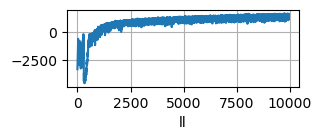

In [ ]:
##########################################    SGNP    ################################################
# training_metrics = train_meta_model(
#     sgnp,
#     training_tasks,
#     training_steps=10_000,
#     batch_size=2,
#     learning_rate=1e-3,
#     final_learning_rate=5e-5,
#     num_samples=5,
#     loss_function='vi',
# )

# fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
# omitted_steps = 100
# for i, (key, value) in enumerate(training_metrics.items()):
#     axes[i].plot(value[omitted_steps:])
#     axes[i].set_xlabel(key)
#     axes[i].grid()
# plt.show()

# torch.save(sgnp, '../saved_models/tetouan-sgnp', pickle_module=dill)
# # sgnp = torch.load('../saved_models/tetouan-sgnp', weights_only=False)


##########################################    CNP    ################################################
# training_metrics = train_meta_model(
#     cnp,
#     training_tasks,
#     training_steps=30_000,
#     batch_size=2,
#     learning_rate=1e-2,
#     final_learning_rate=1e-4,
#     loss_function='npml',
#     include_ctxt_in_trgt=True,
#     ctxt_proportion_range=(0.2, 0.8),
#     # task_subsample_fraction=0.2,
# )

# fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
# if not isinstance(axes, list):
#     axes = [axes]
# omitted_steps = 50
# for i, (key, value) in enumerate(training_metrics.items()):
#     axes[i].plot(value[omitted_steps:])
#     axes[i].set_xlabel(key)
#     axes[i].grid()
# plt.show()

# torch.save(cnp, '../saved_models/tetouan-cnp', pickle_module=dill)


##########################################    ConvCNP    ################################################
# training_metrics = train_meta_model(
#     convcnp,
#     training_tasks,
#     training_steps=10_000,
#     batch_size=2,
#     learning_rate=1e-3,
#     final_learning_rate=5e-5,
#     loss_function='npml',
#     include_ctxt_in_trgt=True,
#     ctxt_proportion_range=(0.2, 0.8),
#     task_subsample_fraction=0.25,
#     use_gpu=True,
# )

# fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
# if not isinstance(axes, list):
#     axes = [axes]
# omitted_steps = 50
# for i, (key, value) in enumerate(training_metrics.items()):
#     axes[i].plot(value[omitted_steps:])
#     axes[i].set_xlabel(key)
#     axes[i].grid()
# plt.show()

# torch.save(convcnp, '../saved_models/tetouan-convcnp', pickle_module=dill)


##########################################    ConvGNP    ################################################
# training_metrics = train_meta_model(
#     convgnp,
#     training_tasks,
#     training_steps=10_000,
#     batch_size=2,
#     learning_rate=1e-3,
#     final_learning_rate=5e-5,
#     loss_function='npml',
#     include_ctxt_in_trgt=True,
#     ctxt_proportion_range=(0.2, 0.8),
#     task_subsample_fraction=0.15,
# )

# fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
# if not isinstance(axes, list):
#     axes = [axes]
# omitted_steps = 50
# for i, (key, value) in enumerate(training_metrics.items()):
#     axes[i].plot(value[omitted_steps:])
#     axes[i].set_xlabel(key)
#     axes[i].grid()
# plt.show()

# torch.save(convgnp, '../saved_models/tetouan-convgnp-sigmoid', pickle_module=dill)


##########################################    TNP-D    ################################################
# training_metrics = train_meta_model(
#     tnp_d,
#     training_tasks,
#     training_steps=10_000,
#     batch_size=2,
#     learning_rate=1e-3,
#     final_learning_rate=5e-5,
#     loss_function='npml',
#     include_ctxt_in_trgt=True,
#     ctxt_proportion_range=(0.2, 0.8),
#     task_subsample_fraction=0.25,
#     use_gpu=True
# )

# fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
# if not isinstance(axes, list):
#     axes = [axes]
# omitted_steps = 50
# for i, (key, value) in enumerate(training_metrics.items()):
#     axes[i].plot(value[omitted_steps:])
#     axes[i].set_xlabel(key)
#     axes[i].grid()
# plt.show()

# torch.save(tnp_d, '../saved_models/tetouan-tnpd', pickle_module=dill)


##########################################    TNP-ND    ################################################
# training_metrics = train_meta_model(
#     tnp_nd,
#     training_tasks,
#     training_steps=10_000,
#     batch_size=2,
#     learning_rate=1e-3,
#     final_learning_rate=5e-5,
#     loss_function='npml',
#     include_ctxt_in_trgt=True,
#     ctxt_proportion_range=(0.2, 0.8),
#     task_subsample_fraction=0.25,
#     use_gpu=True,
# )

# fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
# if not isinstance(axes, list):
#     axes = [axes]
# omitted_steps = 50
# for i, (key, value) in enumerate(training_metrics.items()):
#     axes[i].plot(value[omitted_steps:])
#     axes[i].set_xlabel(key)
#     axes[i].grid()
# plt.show()

# # torch.save(tnp_nd, '../saved_models/tetouan-tnpnd', pickle_module=dill)
# torch.save(tnp_nd, '../saved_models/tetouan-tnpnd', pickle_module=dill)


### Interpolation task

In [ ]:
# tnp_nd = torch.load('../saved_models/tetouan-tnpnd', weights_only=False, pickle_module=dill)

In [ ]:
X_c, y_c = zone3_interp_context
X_t, y_t = zone3_interp_target

################## Train SVGP ##########################
# svgp_prior = models.GPPrior(covariance_function='tetouan',
#                           num_inputs=3,
#                           p1=p1_raw / X_std[0],
#                           p2=p2_raw / X_std[0],
#                          )
# svgp = models.SparseVariationalGaussianProcess(x_dim=3,
#                                                   num_inducing=256,
#                                                   likelihood=models.GaussianLikelihood(sigma_y = 0.02, train_sigma_y=True),
#                                                   prior=svgp_prior,
#                                                   use_titsias=True,
#                                                   )
# svgp.init_inducing_variables(X_c, y_c)

# t1 = timer()
# svgp_training_metrics = train_gp(
#     svgp,
#     X_c,
#     y_c,
#     epochs=10_000,
#     learning_rate=1e-3,
#     final_learning_rate=5e-5,
#     svgp=True,
#     num_samples=5,
# )
# t2 = timer()

# torch.save(svgp, '../saved_models/tetouan-z3-interp_svgp', pickle_module=dill)

# fig, axes = plt.subplots(1, len(svgp_training_metrics), figsize=(3*len(svgp_training_metrics), 1))
# omitted_steps = 50
# for i, (key, value) in enumerate(svgp_training_metrics.items()):
#     axes[i].plot(value[omitted_steps:])
#     axes[i].set_xlabel(key)
#     axes[i].grid()
# plt.show()
#############################################################


with torch.no_grad():
    start = timer()
    # mult_predictive = convgnp(X_c, y_c, X_t)
    # mult_predictive = tnp_nd(X_c, y_c, X_t)
    # end = timer()
    # predictive = torch.distributions.Normal(mult_predictive.mean, mult_predictive.variance.sqrt())

    # predictive = tnp_d(X_c, y_c, X_t)
    predictive = cnp(X_c, y_c, X_t)
    # predictive = convcnp(X_c, y_c, X_t)
    # predictive = sgnp(X_t, X_c, y_c)
    # predictive = svgp(X_t, X_c, y_c)
    end = timer()

root_n = torch.tensor(y_t.shape[0]).sqrt()
print(root_n)
# print("mvt ll: ", mult_predictive.log_prob(y_t.squeeze()) / y_t.shape[0])
print("ll: ", predictive.log_prob(y_t.squeeze()).mean(), predictive.log_prob(y_t.squeeze()).std())# / root_n)
batch_ae = (predictive.mean.squeeze() - y_t.squeeze()).abs()
print("pred mean mae: ", batch_ae.mean(), batch_ae.std())# / root_n)
# print("prediction time: ", t2-t1 + end-start) # use this if evaluating svgp
print("prediction time: ", end-start)


### Extrapolation Task

/Users/thomasrochussen/Documents/meta-sgp/notebooks/../models/covariance_functions.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_p = nn.Parameter(torch.tensor(p).log(), requires_grad=train_p)
100%|██████████| 10000/10000 [56:39<00:00,  2.94it/s, elbo=9.26e+3, e_ll=9.65e+3, kl=393, covariance_function.p1.sigma_f=0.461, covariance_function.p2.sigma_f=0.382, covariance_function.se.sigma_f=0.224, sigma_y=0.0773]    


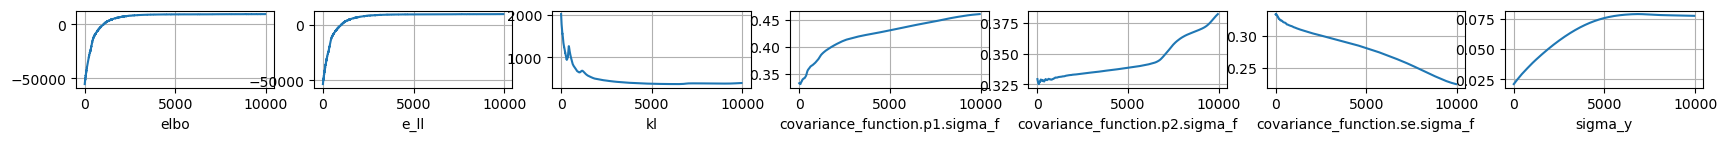

tensor(66.7233)
ll:  tensor(-0.0492) tensor(1.2716)
pred mean mae:  tensor(0.1760) tensor(0.1247)
prediction time:  3399.9744610410416


In [ ]:
X_c, y_c = zone3_extrap_context
X_t, y_t = zone3_extrap_target

################## Train SVGP ##########################
# svgp_prior = models.GPPrior(covariance_function='tetouan',
#                           num_inputs=3,
#                           p1=p1_raw / X_std[0],
#                           p2=p2_raw / X_std[0],
#                          )
# svgp = models.SparseVariationalGaussianProcess(x_dim=3,
#                                                   num_inducing=256,
#                                                   likelihood=models.GaussianLikelihood(sigma_y = 0.02, train_sigma_y=True),
#                                                   prior=svgp_prior,
#                                                   use_titsias=True,
#                                                   )
# svgp.init_inducing_variables(X_c, y_c)

# t1 = timer()
# svgp_training_metrics = train_gp(
#     svgp,
#     X_c,
#     y_c,
#     epochs=10_000,
#     learning_rate=1e-3,
#     final_learning_rate=5e-5,
#     svgp=True,
#     num_samples=5,
# )
# t2 = timer()

# torch.save(svgp, '../saved_models/tetouan-z3-extrap_svgp', pickle_module=dill)

# fig, axes = plt.subplots(1, len(svgp_training_metrics), figsize=(3*len(svgp_training_metrics), 1))
# omitted_steps = 50
# for i, (key, value) in enumerate(svgp_training_metrics.items()):
#     axes[i].plot(value[omitted_steps:])
#     axes[i].set_xlabel(key)
#     axes[i].grid()
# plt.show()
#############################################################


with torch.no_grad():
    start = timer()
    # mult_predictive = convgnp(X_c, y_c, X_t)
    # mult_predictive = tnp_nd(X_c, y_c, X_t)
    # end = timer()
    # predictive = torch.distributions.Normal(mult_predictive.mean, mult_predictive.variance.sqrt())

    # predictive = tnp_d(X_c, y_c, X_t)
    predictive = cnp(X_c, y_c, X_t)
    # predictive = convcnp(X_c, y_c, X_t)
    # predictive = sgnp(X_t, X_c, y_c)
    # predictive = svgp(X_t, X_c, y_c)
    end = timer()

root_n = torch.tensor(y_t.shape[0]).sqrt()
print(root_n)
# print("mvt ll: ", mult_predictive.log_prob(y_t.squeeze()) / y_t.shape[0])
print("ll: ", predictive.log_prob(y_t.squeeze()).mean(), predictive.log_prob(y_t.squeeze()).std())# / root_n)
batch_ae = (predictive.mean.squeeze() - y_t.squeeze()).abs()
print("pred mean mae: ", batch_ae.mean(), batch_ae.std())# / root_n)
# print("prediction time: ", t2-t1 + end-start) # use this if evaluating svgp
print("prediction time: ", end-start)


### Training Loss on Zone 1 context

/Users/thomasrochussen/Documents/meta-sgp/notebooks/../models/covariance_functions.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_p = nn.Parameter(torch.tensor(p).log(), requires_grad=train_p)
100%|██████████| 10000/10000 [30:10<00:00,  5.52it/s, elbo=2.39e+3, e_ll=2.8e+3, kl=405, covariance_function.p1.sigma_f=0.686, covariance_function.p2.sigma_f=0.313, covariance_function.se.sigma_f=0.204, sigma_y=0.122]      


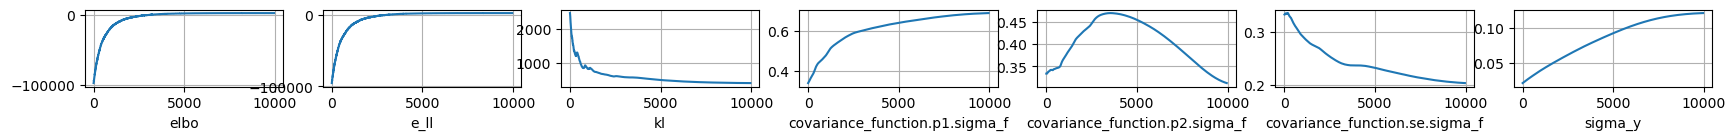

tensor(92.0435)
ll:  tensor(0.6664) tensor(1.1769)
pred mean mae:  tensor(0.0878) tensor(0.0875)


In [ ]:
X, y = training_tasks[0]
torch.manual_seed(42)
X_c, y_c, _, _ = ctxt_trgt_split(X, y, ctxt_proportion_range=(0.49999, 0.50001))
X_t, y_t = X, y

################## Train SVGP ##########################
# svgp_prior = models.GPPrior(covariance_function='tetouan',
#                           num_inputs=3,
#                           p1=p1_raw / X_std[0],
#                           p2=p2_raw / X_std[0],
#                          )
# svgp = models.SparseVariationalGaussianProcess(x_dim=3,
#                                                   num_inducing=256,
#                                                   likelihood=models.GaussianLikelihood(sigma_y = 0.02, train_sigma_y=True),
#                                                   prior=svgp_prior,
#                                                   use_titsias=True,
#                                                   )
# svgp.init_inducing_variables(X_c, y_c)

# svgp_training_metrics = train_gp(
#     svgp,
#     X_c,
#     y_c,
#     epochs=10_000,
#     learning_rate=1e-3,
#     final_learning_rate=5e-5,
#     svgp=True,
#     num_samples=5,
# )

# torch.save(svgp, '../saved_models/tetouan-z1-interp-svgp', pickle_module=dill)

# fig, axes = plt.subplots(1, len(svgp_training_metrics), figsize=(3*len(svgp_training_metrics), 1))
# omitted_steps = 50
# for i, (key, value) in enumerate(svgp_training_metrics.items()):
#     axes[i].plot(value[omitted_steps:])
#     axes[i].set_xlabel(key)
#     axes[i].grid()
# plt.show()
#############################################################


with torch.no_grad():
    # mult_predictive = convgnp(X_c, y_c, X_t)
    # mult_predictive = tnp_nd(X_c, y_c, X_t)
    # predictive = torch.distributions.Normal(mult_predictive.mean, mult_predictive.variance.sqrt())

    # predictive = tnp_d(X_c, y_c, X_t)
    predictive = cnp(X_c, y_c, X_t)
    # predictive = convcnp(X_c, y_c, X_t)
    # predictive = sgnp(X_t, X_c, y_c)
    # predictive = svgp(X_t, X_c, y_c)

root_n = torch.tensor(y_t.shape[0]).sqrt()
print(root_n)
# print("mvt ll: ", mult_predictive.log_prob(y_t.squeeze()) / y_t.shape[0])
print("ll: ", predictive.log_prob(y_t.squeeze()).mean(), predictive.log_prob(y_t.squeeze()).std())# / root_n)
batch_ae = (predictive.mean.squeeze() - y_t.squeeze()).abs()
print("pred mean mae: ", batch_ae.mean(), batch_ae.std())# / root_n)
